# Basic Data Visualization

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jpn--/python-for-transportation-modeling/blob/master/course-content/visualization/two-dim-plots.ipynb)

Python offers a variety of data visualization packages, but
the most fundamental, and most ubiquitous, is 
[matplotlib](https://matplotlib.org/index.html).
Typically, this package most often used with the
[pyplot](https://matplotlib.org/users/pyplot_tutorial.html)
tools, which provides a plotting command interface similar to what
you have with a tool like MATLAB.

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

For example, if you have some data like this:

In [2]:
total_florida_vmt = pd.Series({
    2003: 508_607_851,
    2004: 537_494_319,
    2005: 550_614_540,
    2006: 558_308_386,
    2007: 562_798_032,
    2008: 542_334_376,
    2009: 538_088_986,
    2010: 536_315_479,
    2011: 525_630_013,
    2012: 522_879_155,
    2013: 527_950_180,
    2014: 550_795_629,
    2015: 566_360_175,
    2016: 588_062_806,
    2017: 599_522_329,
})

You can draw a plot and label an axis as simply as this:

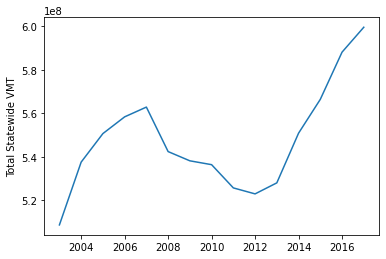

In [3]:
plt.plot(total_florida_vmt)
plt.ylabel("Total Statewide VMT");

You can also plot more than one thing on the same figure.
For example, we can plot both VMT and a 5 year rolling
average of VMT on the same figure, including a legend:

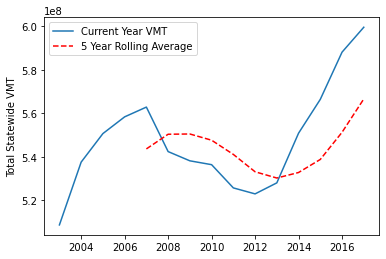

In [4]:
plt.plot(total_florida_vmt, label='Current Year VMT')
plt.plot(total_florida_vmt.rolling(5).mean(), 'r--', label='5 Year Rolling Average')
plt.ylabel("Total Statewide VMT")
plt.legend();

## Multi-Dimensional Data

In this section, we will look at some basic data visualization
techniques for multi-dimensional data.  We'll begin by loading
and preprocessing some data to analyze.

In [5]:
def data_url(filename):
    url = "https://github.com/jpn--/python-for-transportation-modeling/raw/master/example-package/transportation_tutorials/data/"
    return url + filename
    
def get_data(filename):
    if not os.path.isfile(filename):
        import urllib.request
        urllib.request.urlretrieve(data_url(filename), filename)
    return filename

hh = pd.read_csv(get_data('SERPM8-BASE2015-HOUSEHOLDS.csv.gz'), index_col=0)
persons = pd.read_csv(get_data('SERPM8-BASE2015-PERSONS.csv.gz'), index_col=0)
trips = pd.read_csv(get_data('SERPM8-BASE2015-TRIPS.csv.gz'), index_col=0)

In [6]:
# Add household income to persons
persons = persons.merge(hh.income, left_on='hh_id', right_on=hh.hh_id)

# Count of persons per HH
hh = hh.merge(
    persons.groupby('hh_id').size().rename('hhsize'), 
    left_on=['hh_id'], 
    right_index=True,
)

# Count of trips per HH
hh = hh.merge(
    trips.groupby(['hh_id']).size().rename('n_trips'), 
    left_on=['hh_id'], 
    right_index=True,
)

Let's look at what data we have now in the Households table.

In [7]:
hh.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17260 entries, 426629 to 568932
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   hh_id         17260 non-null  int64 
 1   home_mgra     17260 non-null  int64 
 2   income        17260 non-null  int64 
 3   autos         17260 non-null  int64 
 4   transponder   17260 non-null  int64 
 5   cdap_pattern  17260 non-null  object
 6   jtf_choice    17260 non-null  int64 
 7   autotech      17260 non-null  int64 
 8   tncmemb       17260 non-null  int64 
 9   hhsize        17260 non-null  int64 
 10  n_trips       17260 non-null  int64 
dtypes: int64(10), object(1)
memory usage: 1.6+ MB


### Scatter Plots

Suppose we want to understand the relationship between
household income and the number of trips taken.  We can
create a scatterplot of the data using the `plot` method
on the households `pandas.DataFrame`.  This function
takes a `kind` argument that indicates what kind of plot
to generate, plus `x` and `y` arguments that indicate the
names of the columns in the DataFrame to plot.

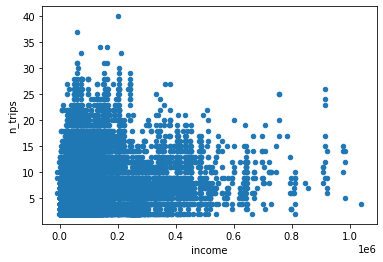

In [8]:
hh.plot(kind='scatter', x='income', y='n_trips');

There's a lot of data plotted here -- so much so that the more
dense parts of the figure just look like a homogenous blob of
blue. One way to change this figure to give it a little more
context is to set the opacity ("alpha") for each point to a 
relatively small value. This results in the individual points 
being de-emphasized, and only areas where there is truely a 
preponderance of points become solid blue.  The `alpha` can
be set as a keywork argument to the `plot` method:

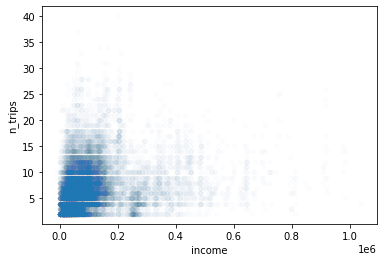

In [9]:
hh.plot(kind='scatter', x='income', y='n_trips', alpha=0.01);

This figure provides a bit more insight into the real distribution
of the data: nearly all of it is in the area below \$200K in household
annual income.  If we want to focus our plot on that region, we can
adjust the axis limits on the x axis, so that it only includes the 
zero to 200K range.  

The `plot` method returns a matplotlib 
[Axes](https://matplotlib.org/api/axes_api.html#the-axes-class) 
object, which can be modified to give the desired result before 
the final figure is rendered.  In this case, we can use the 
`set_xlim` method to set the limits on the x axis:

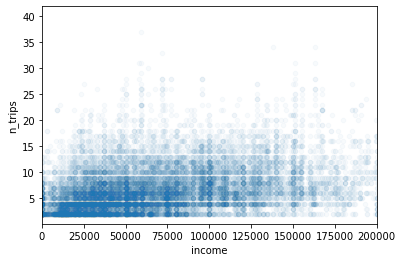

In [10]:
ax = hh.plot(kind='scatter', x='income', y='n_trips', alpha=0.03)
ax.set_xlim(0,200_000);

Plotting trip making against income is interesting, but what if we wanted
to see the relationship between household size and automobile ownership?
We could try the same approach:

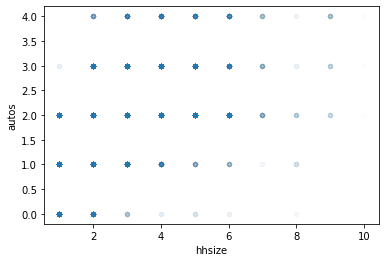

In [11]:
hh.plot(kind='scatter', x='hhsize', y='autos', alpha=0.01);

Unfortunately, there's not a lot of unique values for these two variables, 
and the thousands of points in the scatter plot are all overlaid on a very
limited number of points in the figure.  While the opacity approach does 
permit a bit of differentiation between the unusual points and the others,
it is hard to discern much information in the middle region of the figure.
In fact, it may surprise someone viewing this figure that more than half of
all the observation in the dataset occur on just two points.

### Heatmaps

Rather than a scatter plot, it may be more appropriate to visualize this
data in a heatmap.  This kind of visualization will take the same information
as displayed above, but rather than displaying the intensity of each point by
layering partially transparent points, we can directly compute the mass of 
each point using a pivot table, and then display the data in a color coded
table that is reasonably normalized to help highlight the information you want 
to convey.  To do this, we'll feed the data from a pivot table to the 
[heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html) 
function from the `seaborn` package.

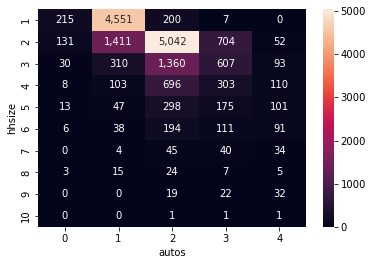

In [12]:
sns.heatmap(
    hh.pivot_table(
        index='hhsize',
        columns='autos',
        aggfunc='size'
    ).fillna(0),
    annot=True,
    fmt=",.0f"
);

The figure above much more clearly articulates the preponderance
of observations in just 2 categories: one person-one car, and 
2 people-2 cars.  In fact, the over abundance of these two values
is washing out much of the other detail in this visualization.
As indicated in the documentation for the 
[heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html) 
function, we can manually override the default upper bound of 
the colorscale by setting a `vmax` argument. This will set 
all of the values above the new maximum to the color at the
maximum point. Since we are also using the `annot` argument 
to add annotations of the actual underlying values, it is still
clear that the two peak values are well above the top of the
colorscale, while a few other cells are shown with some more
useful variation.

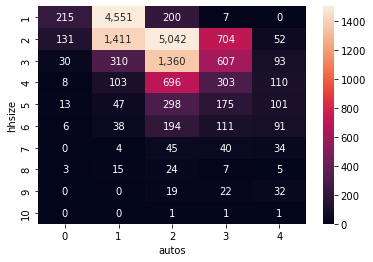

In [13]:
sns.heatmap(
    hh.pivot_table(
        index='hhsize',
        columns='autos',
        aggfunc='size'
    ).fillna(0),
    annot=True,
    fmt=",.0f",
    vmax=1500,
);

The seaborn module provides a number of useful customization 
options as well, which are generally well documented online.
For example, we can change the color scheme, adopting any 
[named colormap](https://matplotlib.org/tutorials/colors/colormaps.html) 
available in the matplotlib package.

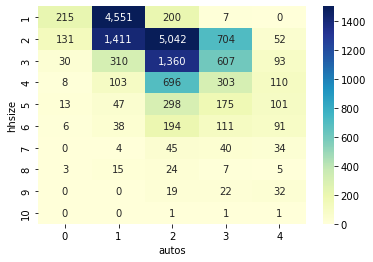

In [14]:
sns.heatmap(
    hh.pivot_table(
        index='hhsize',
        columns='autos',
        aggfunc='size'
    ).fillna(0),
    annot=True,
    fmt=",.0f",
    vmax=1500,
    cmap="YlGnBu",
);

## Box Plots

If one dimension to be visualized is discrete and the other 
is continuous, it may be useful to generate box plots to help
compare distribution.  In these figures, the "box" at the middle
of the plot covers the interquartile range (between the 25th and
75th percentiles, the whiskers show some of the rest of the range
(by default, up to 1.5 times the interquartile range), and dots
show the remaining outliers.

In [15]:
# Create a hhsize variable capped at 5
hh['hhsize5'] = np.fmin(hh['hhsize'], 5)

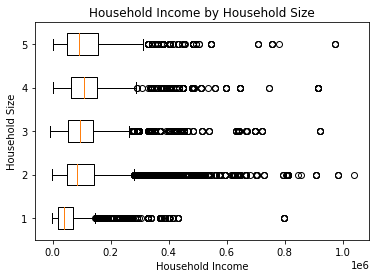

In [16]:
data = list(hh.groupby('hhsize5').income)
plt.boxplot(
    [i[1] for i in data],
    vert=False,
    labels=[i[0] for i in data],
)
plt.title('Household Income by Household Size')
plt.xlabel('Household Income')
plt.ylabel('Household Size');

The figure shown includes quite a lot of outliers across
a very large range of incomes, but much of the detail in
the highest echelons of income is not really important 
for transportation planning analysis.  We can adjust the
figure's limits on the horizontal axis to focus in on the
more relevant portion of the data.

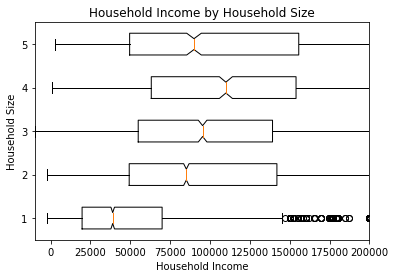

In [17]:
plt.boxplot(
    [i[1] for i in data],
    vert=False,
    labels=[i[0] for i in data],
    notch=True,
)
plt.title('Household Income by Household Size')
plt.xlim(-10_000,200_000)
plt.xlabel('Household Income')
plt.ylabel('Household Size');

## Fancy Figures

More complex visualizations can be created using Seaborn,
and are not too hard to create by following and modifying
recipes found on the [gallery](https://seaborn.pydata.org/examples/index.html) 
in the Seaborn documention.  As an example, this code snippet
is lightly edited from the recipe offered for
[overlapping ridge plots](https://seaborn.pydata.org/examples/kde_ridgeplot.html).

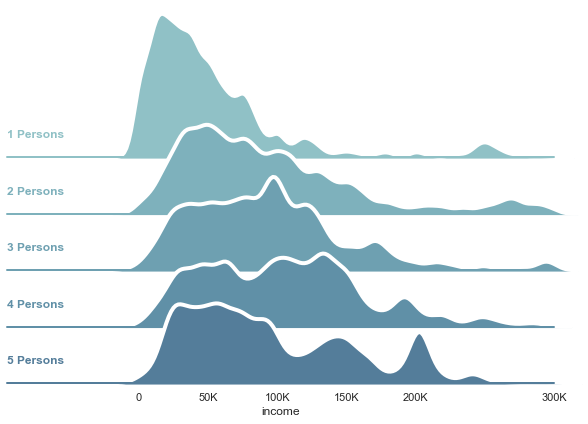

In [18]:
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(
    hh[hh.income<=300_000], row="hhsize5", hue="hhsize5", 
    aspect=7, height=1.25, palette=pal,
    xlim=(-95000,300000)
)

# Draw the densities in a few steps
g.map(sns.kdeplot, "income", clip_on=False, fill=True, alpha=1, lw=1.5, bw_adjust=0.5)
g.map(sns.kdeplot, "income", clip_on=False, color="w", lw=4, bw_adjust=0.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .15, f'{label} Persons', fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "income")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-0.625)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="",
      xticks=[       0,50_000,100_000,150_000,200_000,300_000], 
      xticklabels=['0','50K' ,'100K' ,'150K' ,'200K'  ,'300K',],
     )
g.despine(bottom=True, left=True);
g.row_names = [f'HH Size {i}' for i in g.row_names]